# Import libraries

In [38]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [39]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(
    dataset_path,
    index_col='id'
)
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB


In [41]:
df.describe()

,label
count,7920.000000
mean,0.255808
std,0.436342
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# 3. Preprocessing data

In [42]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

     # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

In [43]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

freqs = get_freqs(df)

In [44]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X

In [45]:
X = []
y = []

for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (7920, 3)
y shape: (7920,)


In [46]:
print(X[0])

[ 1. 13.  2.]


In [47]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [48]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 5544
Number of val samples: 1584
Number of test samples: 792


In [49]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [50]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [51]:

def compute_loss(y_hat, y):
    y_hat = np.clip(
        y_hat, 1e-7, 1 - 1e-7
    )

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


In [52]:
def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat

In [53]:
def compute_gradient(X, y, y_hat):
    return np.dot(
        X.T, (y_hat - y)
    ) / y.size

In [54]:
def update_theta(theta, gradient, lr):
    return theta - lr * gradient

In [55]:
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [56]:
lr = 0.02
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

In [57]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)
        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)
        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.684	Validation loss: 0.681



EPOCH 2:	Training loss: 0.609	Validation loss: 0.606

EPOCH 3:	Training loss: 0.558	Validation loss: 0.556

EPOCH 4:	Training loss: 0.524	Validation loss: 0.521

EPOCH 5:	Training loss: 0.499	Validation loss: 0.496

EPOCH 6:	Training loss: 0.481	Validation loss: 0.479

EPOCH 7:	Training loss: 0.468	Validation loss: 0.465

EPOCH 8:	Training loss: 0.458	Validation loss: 0.455

EPOCH 9:	Training loss: 0.450	Validation loss: 0.447

EPOCH 10:	Training loss: 0.444	Validation loss: 0.441

EPOCH 11:	Training loss: 0.439	Validation loss: 0.435

EPOCH 12:	Training loss: 0.434	Validation loss: 0.431

EPOCH 13:	Training loss: 0.431	Validation loss: 0.427

EPOCH 14:	Training loss: 0.427	Validation loss: 0.424

EPOCH 15:	Training loss: 0.425	Validation loss: 0.421

EPOCH 16:	Training loss: 0.422	Validation loss: 0.419

EPOCH 17:	Training loss: 0.420	Validation loss: 0.416

EPOCH 18:	Training loss: 0.418	Validation loss: 0.414

EPOCH 19:	Training loss: 0.416	Validation loss: 0.412

EPOCH 20:	Trainin

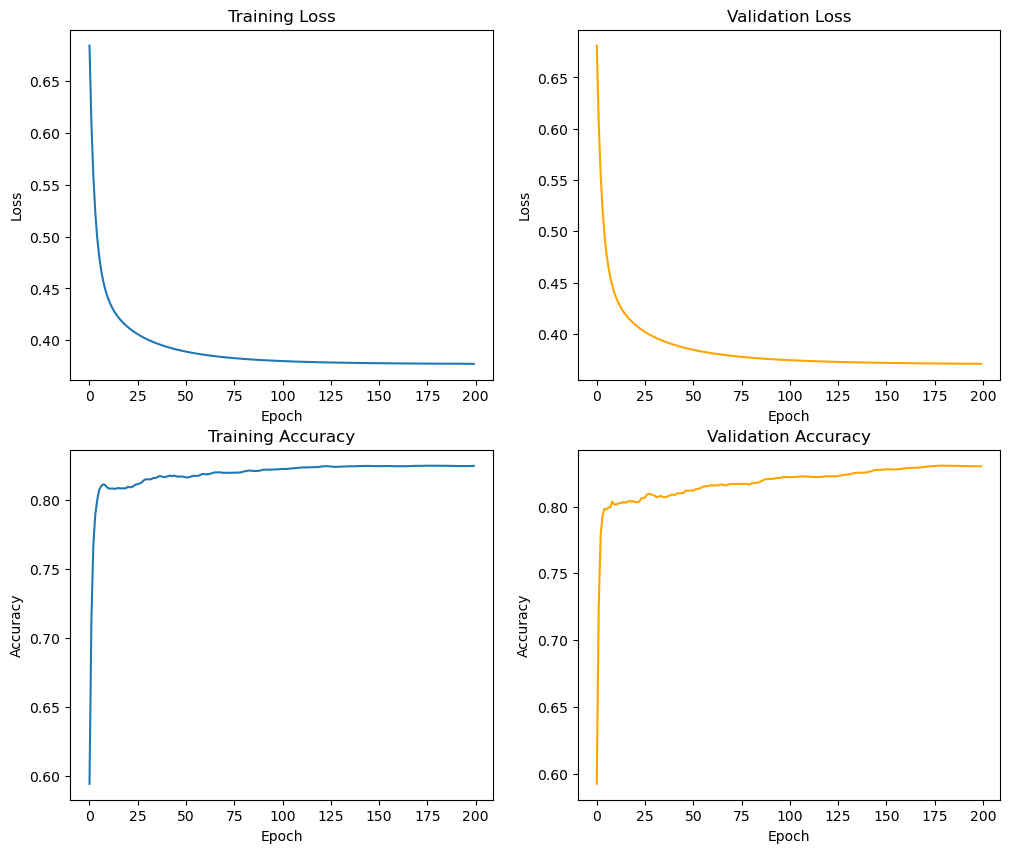

In [58]:


fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [59]:
# Val set
val_set_acc = compute_accuracy(X_val, y_val, theta)
print('Evaluation on validation set:')
print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.8308080808080808


In [60]:
# Test set
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on test set:')
print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.8434343434343434
